In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
import torch
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

whose_working_directory = 1 # 0 = Aleksandra, 1 = Sandro, 2 = Samuel

if whose_working_directory == 0:
  # Aleksandra's working directory
  dir = '/content/drive/My Drive/GraphML/Data'
elif whose_working_directory == 1:
  # Sandro's working directory
  #dir = '/content/drive/My Drive/Data'
  dir = '/content/drive/My Drive/TUDelft/Data'
else:
  # Samuel's working directory
  dir ='/content/drive/My Drive/example_directory/Data'

# Loading Data

In [87]:
"""
The source code in this code block and the data used in this project comes
from the following paper:

Fuli Feng et al. “Temporal Relational Ranking for Stock Prediction”. In: ACM Transactions
on Information Systems 37.2 (Apr. 2019). arXiv:1809.09441 [cs], pp. 1–30. ISSN: 1046-8188,
1558-2868. DOI: 10.1145/3309547. URL: http://arxiv.org/abs/1809.09441 (visited
on 09/25/2025).

Available on github here: https://github.com/fulifeng/Temporal_Relational_Stock_Ranking
"""

def load_EOD_data(data_path, market_name, tickers, steps=1):
    eod_data = []
    masks = []
    ground_truth = []
    base_price = []

    # Determine the expected number of rows based on the first ticker's data
    first_ticker_path = os.path.join(data_path, market_name + '_' + tickers[0] + '_1.csv')
    try:
        first_df = pd.read_csv(first_ticker_path, header=None)
        num_days = first_df.shape[0] - (1 if market_name == 'NASDAQ' else 0) # Remove last row for NASDAQ
        num_features = first_df.shape[1] - 1 # Exclude the date column
    except Exception as e:
        print(f"Error reading first ticker file {first_ticker_path}: {e}")
        return None, None, None, None

    eod_data = np.zeros([len(tickers), num_days, num_features], dtype=np.float32)
    masks = np.ones([len(tickers), num_days], dtype=np.float32)
    ground_truth = np.zeros([len(tickers), num_days], dtype=np.float32) # We're not using this one
    base_price = np.zeros([len(tickers), num_days], dtype=np.float32)

    for index, ticker in enumerate(tickers):
        if index % 50 == 0:
          print(f"Processed [{index}/{tickers.shape[0]}] tickers")
        single_EOD_path = os.path.join(data_path, market_name + '_' + ticker + '_1.csv')

        try:
            single_df = pd.read_csv(single_EOD_path, header=None)
            if market_name == 'NASDAQ':
                single_df = single_df[:-1] # remove the last day since lots of missing data

            # Handle missing values (-1234)
            single_EOD = single_df.values
            mask_row_indices, mask_col_indices = np.where(np.abs(single_EOD + 1234) < 1e-8)
            single_EOD[mask_row_indices, mask_col_indices] = 1.1 # Replace missing values

            # Update masks based on missing closing price
            missing_close_indices = np.where(np.abs(single_EOD[:, -1] + 1234) < 1e-8)[0]
            masks[index, missing_close_indices] = 0.0

            eod_data[index, :, :] = single_EOD[:, 1:] # Exclude date column
            base_price[index, :] = single_EOD[:, -1]

        except Exception as e:
            print(f"Error reading ticker file {single_EOD_path}: {e}")
            # Mark all days for this ticker as invalid if file reading fails
            masks[index, :] = 0.0


    print('eod data shape:', eod_data.shape)
    return eod_data, masks, ground_truth, base_price


def load_relation_data(relation_file):
    relation_encoding = np.load(relation_file)
    print('relation encoding shape:', relation_encoding.shape)
    rel_shape = [relation_encoding.shape[0], relation_encoding.shape[1]]
    mask_flags = np.equal(np.zeros(rel_shape, dtype=int),
                          np.sum(relation_encoding, axis=2))
    mask = np.where(mask_flags, np.ones(rel_shape) * -1e9, np.zeros(rel_shape))
    return relation_encoding, mask

In [88]:
# Select the market
market = "NYSE" # "NYSE" (1737 companies) or "NASDAQ" (1026 companies)

# Use subset of data for the experiments
n_companies = -1 # -1 for all


if n_companies == -1:
  if market == "NYSE":
    n_companies = 1737
  elif market == "NASDAQ":
    n_companies = 1026

# Load industry relation data
industry_encodings, industry_mask = load_relation_data(dir+f'/relation/sector_industry/{market}_industry_relation.npy')
industry_encodings = industry_encodings[:n_companies, :n_companies, :]
industry_mask = industry_mask[:n_companies, :n_companies]
print(f"industry_encodings shape: {industry_encodings.shape}")

# Load wiki relation data
wiki_encodings, wiki_mask = load_relation_data(dir+f'/relation/wikidata/{market}_wiki_relation.npy')
wiki_encodings = wiki_encodings[:n_companies, :n_companies, :]
wiki_mask = wiki_mask[:n_companies, :n_companies]
print(f"wiki_encodings shape: {wiki_encodings.shape}")

# Load company names
tickers = np.loadtxt(dir+f'/{market}_tickers.csv', dtype=str)
print(f"tickers shape (# of companies): {tickers.shape}")

# Load financial data (may take 5-10 minutes!)
eod_data, eod_masks, eod_ground_truth, eod_base_price = load_EOD_data(dir+"/2013-01-01", market, tickers[:n_companies])

relation encoding shape: (1737, 1737, 108)
industry_encodings shape: (1737, 1737, 108)
relation encoding shape: (1737, 1737, 33)
wiki_encodings shape: (1737, 1737, 33)
tickers shape (# of companies): (1737,)
Processed [0/1737] tickers
Processed [50/1737] tickers
Processed [100/1737] tickers
Processed [150/1737] tickers
Processed [200/1737] tickers
Processed [250/1737] tickers
Processed [300/1737] tickers
Processed [350/1737] tickers
Processed [400/1737] tickers
Processed [450/1737] tickers
Processed [500/1737] tickers
Processed [550/1737] tickers
Processed [600/1737] tickers
Processed [650/1737] tickers
Processed [700/1737] tickers
Processed [750/1737] tickers
Processed [800/1737] tickers
Processed [850/1737] tickers
Processed [900/1737] tickers
Processed [950/1737] tickers
Processed [1000/1737] tickers
Processed [1050/1737] tickers
Processed [1100/1737] tickers
Processed [1150/1737] tickers
Processed [1200/1737] tickers
Processed [1250/1737] tickers
Processed [1300/1737] tickers
Proce

In [10]:
# Define Portfolio Investment Functions
import numpy as np
import matplotlib.pyplot as plt

def calculate_returns(pred_price, actual_price, first_day):
    # Calculate the percentage change (expected return) for each company
    # Expected return for each company on the next day
    pred_pct_change = (pred_price[1:] - pred_price[:-1]) / pred_price[:-1]
    actual_pct_change = (actual_price[1:] - actual_price[:-1]) / actual_price[:-1]

    # Initialize arrays to store expected returns and actual returns
    expected_returns = []
    actual_returns = []

    portfolio_value = 1  # Initial portfolio value is 1 unit of money
    portfolio_values = [portfolio_value]

    # Iterate over each day starting from the 'first_day'
    for day in range(first_day, len(pred_pct_change)):
        # Calculate the expected returns for the current day
        # For each day, we sort the companies based on predicted returns and pick the top 10
        sorted_indices = np.argsort(pred_pct_change[day])  # Indices sorted by predicted change
        top_10_indices = sorted_indices[-10:]  # Indices of top 10 companies with highest predicted return

        # Calculate the expected and actual return for the top 10 companies
        expected_return_today = np.mean(pred_pct_change[day, top_10_indices])
        actual_return_today = np.mean(actual_pct_change[day, top_10_indices])

        # Append the results to the lists
        expected_returns.append(expected_return_today)
        actual_returns.append(actual_return_today)

        # Update portfolio value based on actual return
        portfolio_value *= (1 + actual_return_today)  # Reinvest the portfolio value
        portfolio_values.append(portfolio_value)

    # Convert lists to numpy arrays for easy plotting
    expected_returns = np.array(expected_returns)
    actual_returns = np.array(actual_returns)

    return expected_returns, actual_returns, np.array(portfolio_values)

def plot_returns(expected_returns, actual_returns):
    # Plot the expected vs actual returns
    plt.figure(figsize=(10, 6))
    plt.plot(expected_returns, label='Expected Return', color='blue', linestyle='-', marker='o')
    plt.plot(actual_returns, label='Actual Return', color='red', linestyle='--', marker='x')
    plt.title('Expected vs Actual Returns of Top 10 Companies')
    plt.xlabel('Time (Days)')
    plt.ylabel('Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_portfolio_value(portfolio_values):
    # Plot the portfolio value over time
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='green', linestyle='-', marker='o')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Prepare Adjacency Matrix

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [12]:
# ============================================================================
# Data Preparation Functions
# ============================================================================

def build_adjacency_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device):
    """
    Build normalized adjacency matrix from relation encodings and masks

    Args:
        industry_encodings: [num_companies, num_companies, num_relation_types]
        industry_mask: [num_companies, num_companies] (-1e9 for no relation, 0 for valid)
        wiki_encodings: [num_companies, num_companies, num_relation_types]
        wiki_mask: [num_companies, num_companies]

    Returns:
        adjacency_matrix: [num_companies, num_companies] - normalized adjacency
    """
    # Combine relation encodings by summing across relation types
    industry_adj = torch.sum(industry_encodings, dim=-1)  # [companies, companies]
    wiki_adj = torch.sum(wiki_encodings, dim=-1)

    # Combine both relation types
    combined_adj = industry_adj + wiki_adj

    # Apply masks: where mask is -1e9 (no relation), set adjacency to 0
    combined_mask = industry_mask + wiki_mask
    combined_adj = torch.where(combined_mask < -1e8, torch.zeros_like(combined_adj), combined_adj)

    # Normalize: row-wise normalization (each row sums to 1)
    row_sums = combined_adj.sum(dim=1, keepdim=True)
    adjacency_matrix = combined_adj / (row_sums + 1e-8) # [0, 1)

    return adjacency_matrix.to(device)


def prepare_data(eod_data, masks, base_price, device, window_size=20, prediction_horizon=1):
    """
    Create sliding windows for time series prediction with mask handling

    Args:
        eod_data: [num_companies, num_days, num_features]
        masks: [num_companies, num_days] - 1.0 for valid, 0.0 for missing
        base_price: [num_companies, num_days] - closing price of stock
        window_size: Number of historical days to use as input
        prediction_horizon: Number of days ahead to predict (usually 1)

    Returns:
        X: Input windows [num_samples, num_companies, window_size, num_features]
        y: Target returns [num_samples, num_companies, prediction_horizon]
        sample_masks: Valid sample indicators [num_samples, num_companies]
    """
    num_companies, num_days, num_features = eod_data.shape
    num_samples = num_days - window_size - prediction_horizon + 1

    X = torch.zeros(num_samples, num_companies, window_size, num_features, device=device)
    y = torch.zeros(num_samples, num_companies, prediction_horizon, device=device)
    sample_masks = torch.zeros(num_samples, num_companies, device=device)

    for i in range(num_samples):
        X[i] = eod_data[:, i:i+window_size, :]
        y[i, :, :] = base_price[:, i+window_size : i+window_size+prediction_horizon] #

        # A sample is valid if all days in the window AND the target day are valid
        window_valid = masks[:, i:i+window_size].min(dim=1)[0]  # [num_companies]
        target_valid = masks[:, i+window_size : i+window_size+prediction_horizon].min(dim=1)[0]
        sample_masks[i] = window_valid * target_valid

    return X, y, sample_masks

In [13]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load data
num_companies = eod_data.shape[0] # Change if using subset
num_days = 1245
num_features = 5

eod_data = torch.tensor(eod_data)
masks = torch.tensor(eod_masks)
price_prediction = torch.tensor(eod_base_price) # We predict stock price

# Relation data
industry_encodings = torch.tensor(industry_encodings)
industry_mask = torch.tensor(industry_mask)
wiki_encodings = torch.tensor(wiki_encodings)
wiki_mask = torch.tensor(wiki_mask)

print(f"EOD data shape: {eod_data.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Ground truth shape: {price_prediction.shape}")
print(f"Industry encodings shape: {industry_encodings.shape}")

Using device: cuda
EOD data shape: torch.Size([1026, 1245, 5])
Masks shape: torch.Size([1026, 1245])
Ground truth shape: torch.Size([1026, 1245])
Industry encodings shape: torch.Size([1026, 1026, 97])


In [19]:
def get_adjacency_matrix(prediction_horizon=1, window_size=100):
  # Build adjacency matrix from relations
  adjacency_matrix = build_adjacency_matrix(
      industry_encodings, industry_mask,
      wiki_encodings, wiki_mask,
      device=device
  )
  #print(f"Adjacency matrix shape: {adjacency_matrix.shape}")

  # Prepare temporal data with masks
  X_train, y_train, train_masks = prepare_data(
      eod_data, masks, price_prediction,
      window_size=window_size,
      device=device,
      prediction_horizon=prediction_horizon
  )
  #print(f"Training data: X={X_train.shape}, y={y_train.shape}, masks={train_masks.shape}")

  return (adjacency_matrix, X_train, y_train, train_masks)


prediction_horizon=1
window_size=20

adjacency_matrix, X_data, y_data, data_masks = get_adjacency_matrix(prediction_horizon, window_size)

# Train, validation, and test sizes from temporal ranking paper
train_size = 736 # int(0.6 * len(X_data))
validation_size = 252 # int(0.2 * len(X_data))
test_size = 237 # int(0.2 * len(X_data))

# Split data into train, validation, and test sets
X_train, X_val, X_test = X_data[:train_size], X_data[train_size:train_size+validation_size], X_data[train_size+validation_size:]
y_train, y_val, y_test = y_data[:train_size], y_data[train_size:train_size+validation_size], y_data[train_size+validation_size:]
train_masks, val_masks, test_masks = data_masks[:train_size], data_masks[train_size:train_size+validation_size], data_masks[train_size+validation_size:]

print("train_masks.sum():", train_masks.sum())
print("train_masks size:", train_masks.shape[0]*train_masks.shape[1])
print("train size: ", X_train.shape)
print("validation size: ", X_val.shape)
print("test size: ", X_test.shape)

train_masks.sum(): tensor(755136., device='cuda:0')
train_masks size: 755136
train size:  torch.Size([736, 1026, 20, 5])
validation size:  torch.Size([252, 1026, 20, 5])
test size:  torch.Size([237, 1026, 20, 5])


# Trivial Baseline Model & Some Market Statistics
Predicts the next day's price as today's price

In [27]:
import torch
import numpy as np
import time
import pandas as pd

log_baseline = []
epochs = 1  # Only one pass needed for baseline
train_start_time = time.time()

criterion = torch.nn.MSELoss(reduction='none')

# Predict y_t = y_{t-1}
pred_train = torch.zeros_like(y_train)
pred_test = torch.zeros_like(y_test)

pred_train[1:] = y_train[:-1]
pred_test[1:] = y_test[:-1]

pred_train[0] = y_train[0]
pred_test[0] = y_test[0]

# Compute masked loss
loss_per_sample = criterion(pred_train, y_train)
masked_loss = loss_per_sample * train_masks.unsqueeze(-1)
loss = masked_loss.sum() / (train_masks.sum() + 1e-8)

test_loss_per_sample = criterion(pred_test, y_test)
test_masked_loss = test_loss_per_sample * test_masks.unsqueeze(-1)
test_loss = test_masked_loss.sum() / (test_masks.sum() + 1e-8)

# Portfolio evaluation
pred_price = pred_test.squeeze(-1).cpu().numpy()  # [samples, companies]
actual_price = y_test.squeeze(-1).cpu().numpy()
first_day = 0

expected_returns, actual_returns, portfolio_values = calculate_returns(pred_price, actual_price, first_day)
portfolio_value = portfolio_values[-1]

# Logging
log_baseline.append([0, loss.item(), test_loss.item(), 0, portfolio_value])

print(f"Epoch [{1}/{1}] | "
      f"Train Loss: {loss.item():.6f} | "
      f"Test Loss: {test_loss.item():.6f} | "
      f"Portfolio Value: {portfolio_value:.6f}")

# Save log
log_df = pd.DataFrame(log_baseline, columns=['Epoch', 'Train Loss', 'Test Loss', 'Epoch Time (s)', 'Portfolio Value'])
log_df['Avg Epoch Time (s)'] = 0

output_path = dir + '/output/log_NASDAQ_baseline.csv'
log_df.to_csv(output_path, index=False)

print(f"\nNaive baseline completed. Log saved to {output_path}")

Epoch [1/1] | Train Loss: 0.000428 | Test Loss: 0.000191 | Portfolio Value: 0.836247

Naive baseline completed. Log saved to /content/drive/My Drive/TUDelft/Data/output/log_NASDAQ_baseline.csv


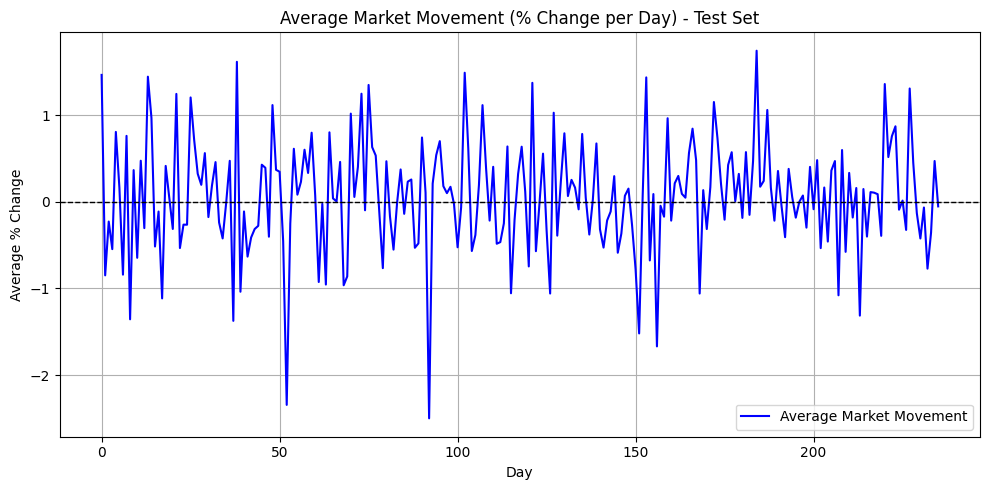

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_average_market_movement(y_data, set_name="Test"):
    """
    Compute and plot the average daily percentage change (market movement)
    across all companies.

    Args:
        y_data (torch.Tensor or np.ndarray): [samples, companies, 1] price data.
        set_name (str): Label for the plot (e.g. 'Train' or 'Test').
    """
    # Convert to numpy if it's a tensor
    if isinstance(y_data, torch.Tensor):
        y_data = y_data.squeeze(-1).cpu().numpy()  # [samples, companies]

    # Compute percentage change along the time axis (daily returns)
    pct_change = (y_data[1:] - y_data[:-1]) / (y_data[:-1] + 1e-8)

    # Compute average across all companies for each day
    avg_market_movement = np.mean(pct_change, axis=1)  # shape: [samples-1]

    # Plot the average market movement
    plt.figure(figsize=(10, 5))
    plt.plot(avg_market_movement * 100, color='blue', label='Average Market Movement')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Average Market Movement (% Change per Day) - {set_name} Set")
    plt.xlabel("Day")
    plt.ylabel("Average % Change")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the computed values in case you want to use them later
    return avg_market_movement

# Example usage
avg_movement = plot_average_market_movement(y_test, set_name="Test")

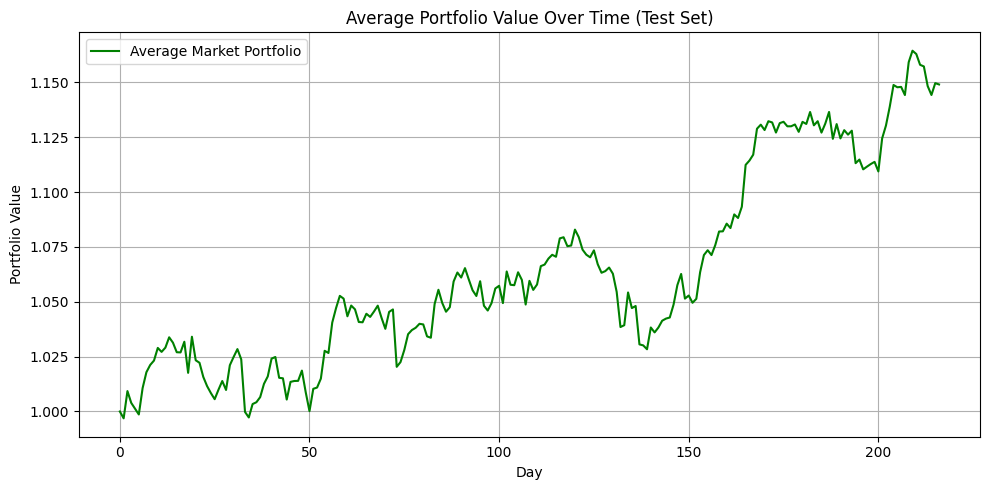

Final average portfolio value: 1.1491
Total return: 14.91%


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_portfolio_value(y_data, set_name="Test"):
    """
    Compute the average portfolio value per day starting at 1.
    This assumes equal-weight investment across all companies.

    Args:
        y_data (torch.Tensor or np.ndarray): [samples, companies, 1] price data
        set_name (str): name of dataset (for plot labeling)
    Returns:
        np.ndarray: portfolio value over time
    """
    # Convert to numpy if it's a tensor
    if isinstance(y_data, torch.Tensor):
        y_data = y_data.squeeze(-1).cpu().numpy()  # [samples, companies]

    # Compute daily percentage change for each company
    pct_change = (y_data[1:] - y_data[:-1]) / (y_data[:-1] + 1e-8)

    # Average across companies for each day
    avg_daily_return = np.mean(pct_change, axis=1)  # shape [samples-1]

    # Initialize portfolio
    portfolio_value = [1.0]
    for r in avg_daily_return:
        portfolio_value.append(portfolio_value[-1] * (1 + r))

    portfolio_value = np.array(portfolio_value)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value, color='green', label='Average Market Portfolio')
    plt.title(f"Average Portfolio Value Over Time ({set_name} Set)")
    plt.xlabel("Day")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Final average portfolio value: {portfolio_value[-1]:.4f}")
    print(f"Total return: {(portfolio_value[-1]-1)*100:.2f}%")

    return portfolio_value

# Example usage:
avg_portfolio = compute_average_portfolio_value(y_test[20:], set_name="Test") # Ignore first 20 days because the real models use 217 days

## Simple G-Var

In [32]:
"""
Simple G-VAR (Graph Vector AutoRegression) for Stock Price Prediction
Combines temporal dependencies (VAR) with graph structure (GNN)
Updated to match the paper's data format
"""

# ============================================================================
# Simple G-Var
# ============================================================================

class GVarModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_companies, device, K=2):
        """
        Args:
            input_dim: Number of features * window_size per company
            output_dim: Prediction dimension (1 for return prediction)
            num_companies: Number of stocks (e.g., 150)
            K: Number of graph hops
        """
        super(GVarModel, self).__init__()
        self.device = device
        self.K = K
        self.num_companies = num_companies
        self.output_dim = output_dim

        self.graph_layers = nn.ModuleList([
            nn.Linear(input_dim, 1) for _ in range(K + 1)
        ])

    def forward(self, x, adjacency_matrix):
        """
        Args:
            x: Historical data [batch, num_companies, time_steps, input_dim]
            adjacency_matrix: Graph structure [num_companies, num_companies]
        Returns:
            predictions: [batch, num_companies, output_dim]
        """
        batch_size = x.shape[0]

        # Step 1: Extract temporal features for each stock independently
        # Reshape to process all companies' time series
        x_reshaped = x.view(x.shape[0], x.shape[1], -1)  # [batch, companies, time_steps * features]

        # Compute powers of adjacency matrix: A^0 (self), A^1 (neighbors), A^2 (2-hop), ...
        S_powers = [torch.eye(self.num_companies, device=adjacency_matrix.device)]
        for k in range(self.K):
            S_powers.append(torch.matmul(S_powers[-1], adjacency_matrix))

        # Step 2: Aggregate information from k-hop neighbors
        output = torch.zeros(x.shape[0], x.shape[1], self.output_dim, device=self.device)
        for k in range(self.K + 1):
            # Transform features at each hop level
            transformed = self.graph_layers[k](x_reshaped)  # [batch, companies, hidden_dim]
            #transformed = torch.relu(self.graph_layers[k](x_reshaped))

            # Aggregate from k-hop neighbors: S^k @ transformed
            aggregated = torch.matmul(S_powers[k], transformed)  # [batch, companies, hidden_dim]
            output += aggregated

        return output

Epoch [50/5000], Loss: 0.003720
Epoch [100/5000], Loss: 0.002472
Epoch [150/5000], Loss: 0.001681
Epoch [200/5000], Loss: 0.001246
Epoch [250/5000], Loss: 0.001020
Epoch [300/5000], Loss: 0.000902
Epoch [350/5000], Loss: 0.000835
Epoch [400/5000], Loss: 0.000791
Epoch [450/5000], Loss: 0.000757
Epoch [500/5000], Loss: 0.000729
Epoch [550/5000], Loss: 0.000703
Epoch [600/5000], Loss: 0.000680
Epoch [650/5000], Loss: 0.000658
Epoch [700/5000], Loss: 0.000638
Epoch [750/5000], Loss: 0.000619
Epoch [800/5000], Loss: 0.000601
Epoch [850/5000], Loss: 0.000585
Epoch [900/5000], Loss: 0.000569
Epoch [950/5000], Loss: 0.000555
Epoch [1000/5000], Loss: 0.000541
Epoch [1050/5000], Loss: 0.000528
Epoch [1100/5000], Loss: 0.000516
Epoch [1150/5000], Loss: 0.000505
Epoch [1200/5000], Loss: 0.000494
Epoch [1250/5000], Loss: 0.000483
Epoch [1300/5000], Loss: 0.000474
Epoch [1350/5000], Loss: 0.000492
Epoch [1400/5000], Loss: 0.000458
Epoch [1450/5000], Loss: 0.000451
Epoch [1500/5000], Loss: 0.000444


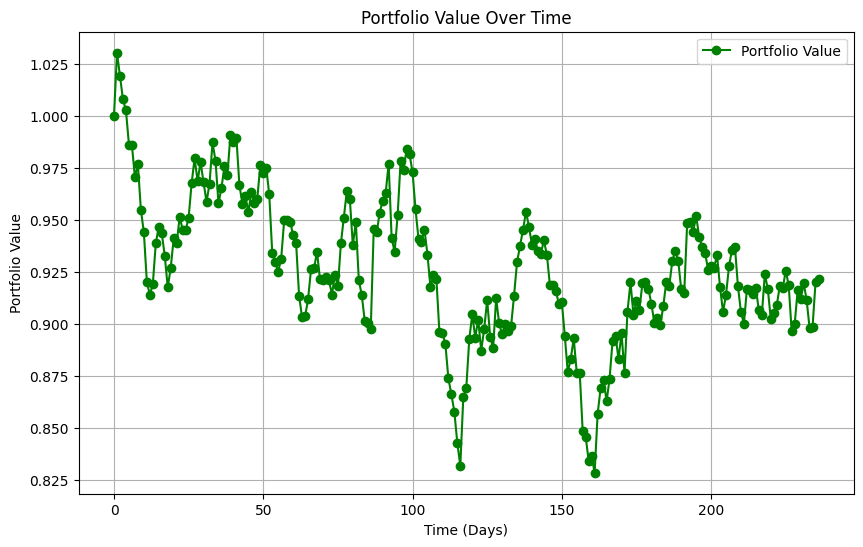

Epoch [5000/5000], Loss: 0.000331


In [33]:
# Initialize model
model = GVarModel(
    input_dim=num_features*window_size,
    output_dim=prediction_horizon, # = prediction_horizon
    num_companies=num_companies,
    device=device,
    K=1
).to(device)

# Normalise adjacency_matrix (makes training more stable)
D = adjacency_matrix.sum(dim=1)
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(D + 1e-8))
Adj_norm = D_inv_sqrt @ adjacency_matrix @ D_inv_sqrt

# Training with masked loss
criterion = nn.MSELoss(reduction='none')  # Don't reduce yet, we'll apply masks
#criterion = nn.L1Loss(reduction='none')  # Don't reduce yet, we'll apply masks
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0005 for K=2 and lr = 0.001 for K=1 perform similarly
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

import time
log_gvar = []
train_start_time = time.time()

epochs = 5000
for epoch in range(epochs):
    epoch_start_time = time.time()

    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(X_train, Adj_norm)  # [batch, companies, 1]
    #predictions = model(X_train, torch.eye(num_companies, device=device))  # [batch, companies, 1]

    # Calculate masked loss (only on valid samples)
    loss_per_sample = criterion(predictions, y_train)  # [batch, companies, 1]
    masked_loss = loss_per_sample * train_masks.unsqueeze(-1)  # Apply mask


    # Average loss over valid samples only
    num_valid = train_masks[:predictions.size(0)].sum() + 1e-8
    #loss = masked_loss[:,:,model.output_dim-1].sum() / num_valid # Loss only for prediction_horizon day in future (1 day)
    loss = masked_loss.sum() / num_valid # Loss for all days up to prediction_horizon

    # Backward pass
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    # For logging
    portfolio_value = 0
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test, Adj_norm) # torch.eye(num_companies, device=device))
        test_loss_per_sample = criterion(test_predictions, y_test)
        test_masked_loss = test_loss_per_sample * test_masks.unsqueeze(-1)
        test_loss = test_masked_loss.sum() / (test_masks.sum() + 1e-8)

        pred_price = test_predictions.squeeze(-1).cpu().numpy()  # [samples, companies]
        actual_price = y_test.squeeze(-1).cpu().numpy()
        first_day = 0

        expected_returns, actual_returns, portfolio_values = calculate_returns(pred_price, actual_price, first_day)

        if epoch == epochs-1:
          plot_portfolio_value(portfolio_values)

        portfolio_value = portfolio_values[-1]

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    log_gvar.append([epoch, loss.item(), test_loss.item(), epoch_time, portfolio_value])

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')



## Sarima Model

In [35]:
# ============================================================================
# SARIMA Layer Implementation
# ============================================================================

class SARIMALayer(nn.Module):
    def __init__(self, time_steps, features, ar_order=1, ma_order=1, seasonal_period=365, output_dim=1):
        """
        Learnable SARIMA-inspired layer for time series features

        Args:
            time_steps: Number of historical time steps
            features: Number of features per time step
            ar_order: Autoregressive order (p) - how many past values to use
            ma_order: Moving average order (q) - how many past errors to use
            seasonal_period: Seasonal period (e.g., 20 for monthly pattern in daily data)
            output_dim: Output dimension (usually 1 for single prediction)
        """
        super(SARIMALayer, self).__init__()
        self.time_steps = time_steps
        self.features = features
        self.ar_order = min(ar_order, time_steps)  # Can't use more lags than we have
        self.ma_order = ma_order
        self.seasonal_period = seasonal_period

        # AR component: learnable weights for past p values
        # For each feature, learn weights for past ar_order time steps
        self.ar_weights = nn.Parameter(torch.randn(features, self.ar_order) * 0.01)

        # Seasonal AR component: learnable weights for seasonal lags
        # Number of seasonal lags we can use
        self.num_seasonal_lags = max(1, time_steps // seasonal_period)
        self.seasonal_ar_weights = nn.Parameter(torch.randn(features, self.num_seasonal_lags) * 0.01)

        # MA component: learnable weights for moving average of residuals
        # We'll use a simple exponential moving average approach
        self.ma_weights = nn.Parameter(torch.randn(features, self.ma_order) * 0.01)

        # Feature-wise bias terms
        self.bias = nn.Parameter(torch.zeros(features))

        # Final projection layer to combine all components
        self.projection = nn.Linear(features * 3, output_dim)  # 3 components: AR, SAR, MA

    def forward(self, x):
        """
        Args:
            x: Input [batch, companies, time_steps * features]
        Returns:
            output: [batch, companies, output_dim]
        """
        batch_size, num_companies, _ = x.shape

        # Reshape to separate time and features
        x_reshaped = x.view(batch_size, num_companies, self.time_steps, self.features)
        # [batch, companies, time_steps, features]

        # ===== AR Component: Autoregressive =====
        # For each feature, compute weighted sum of past ar_order values
        ar_output = torch.zeros(batch_size, num_companies, self.features, device=x.device)

        for i in range(self.ar_order):
            # Get values from (time_steps - ar_order + i) time step
            lag_idx = self.time_steps - self.ar_order + i
            if lag_idx >= 0:
                # x_reshaped[:, :, lag_idx, :] has shape [batch, companies, features]
                # ar_weights[:, i] has shape [features]
                ar_output += x_reshaped[:, :, lag_idx, :] * self.ar_weights[:, i].unsqueeze(0).unsqueeze(0)

        # ===== Seasonal AR Component =====
        seasonal_output = torch.zeros(batch_size, num_companies, self.features, device=x.device)

        for i in range(self.num_seasonal_lags):
            # Get seasonal lag: t - seasonal_period * (i+1)
            seasonal_lag_idx = self.time_steps - self.seasonal_period * (i + 1)
            if seasonal_lag_idx >= 0:
                seasonal_output += x_reshaped[:, :, seasonal_lag_idx, :] * \
                                  self.seasonal_ar_weights[:, i].unsqueeze(0).unsqueeze(0)

        # ===== MA Component: Moving Average of Recent Values =====
        # Use last ma_order time steps and compute weighted moving average
        ma_output = torch.zeros(batch_size, num_companies, self.features, device=x.device)

        for i in range(self.ma_order):
            lag_idx = self.time_steps - self.ma_order + i
            if lag_idx >= 0:
                ma_output += x_reshaped[:, :, lag_idx, :] * self.ma_weights[:, i].unsqueeze(0).unsqueeze(0)

        # ===== Combine Components =====
        # Add bias to each component
        ar_output = ar_output + self.bias
        seasonal_output = seasonal_output
        ma_output = ma_output

        # Concatenate all components
        combined = torch.cat([ar_output, seasonal_output, ma_output], dim=-1)
        # [batch, companies, features * 3]

        # Project to output dimension
        output = self.projection(combined)  # [batch, companies, output_dim]

        return output

In [36]:
class GSarimaModel(nn.Module):
    def __init__(self, time_steps, input_dim, num_companies, device, output_dim=1, K=2,
                 ar_order=1, ma_order=1, seasonal_period=365):
        """
        Args:
            time_steps: Number of historical time steps (window_size)
            input_dim: Number of features per company (e.g., 5 for OHLCV without close)
            num_companies: Number of stocks (e.g., 150)
            device: Device for tensors (cuda/cpu)
            K: Number of graph convolution hops
            ar_order: Autoregressive order for SARIMA
            ma_order: Moving average order for SARIMA
            seasonal_period: Seasonal period for SARIMA
        """
        super(GSarimaModel, self).__init__()
        self.K = K
        self.num_companies = num_companies
        self.device = device
        self.output_dim = output_dim

        # SARIMA-based graph convolution layers
        # Each hop level has its own SARIMA temporal processor
        self.graph_layers = nn.ModuleList([
            SARIMALayer(time_steps, input_dim, ar_order, ma_order, seasonal_period, output_dim)
            for _ in range(K + 1)
        ])

    def forward(self, x, adjacency_matrix):
        """
        Args:
            x: Historical data [batch, num_companies, time_steps, input_dim]
            adjacency_matrix: Graph structure [num_companies, num_companies]
        Returns:
            predictions: [batch, num_companies, 1]
        """
        batch_size = x.shape[0]

        # Flatten temporal dimension for SARIMA processing
        # x shape: [batch, companies, time_steps, features]
        x_flat = x.view(batch_size, self.num_companies, -1)  # [batch, companies, time_steps*features]

        # Compute powers of adjacency matrix: A^0 (self), A^1 (neighbors), A^2 (2-hop)
        S_powers = [torch.eye(self.num_companies, device=self.device)]
        for k in range(self.K):
            S_powers.append(torch.matmul(S_powers[-1], adjacency_matrix))

        # Apply SARIMA + graph convolution at each hop level
        output = torch.zeros(batch_size, self.num_companies, self.output_dim, device=self.device)

        for k in range(self.K + 1):
            # Apply SARIMA temporal processing
            temporal_features = self.graph_layers[k](x_flat)  # [batch, companies, 1]

            # Aggregate from k-hop neighbors using graph structure
            aggregated = torch.matmul(S_powers[k], temporal_features)  # [batch, companies, 1]
            output += aggregated

        return output

Epoch [50/5000], Loss: 0.003702
Epoch [100/5000], Loss: 0.001449
Epoch [150/5000], Loss: 0.001229
Epoch [200/5000], Loss: 0.001012
Epoch [250/5000], Loss: 0.000837
Epoch [300/5000], Loss: 0.000713
Epoch [350/5000], Loss: 0.000627
Epoch [400/5000], Loss: 0.000566
Epoch [450/5000], Loss: 0.000521
Epoch [500/5000], Loss: 0.000487
Epoch [550/5000], Loss: 0.000461
Epoch [600/5000], Loss: 0.000441
Epoch [650/5000], Loss: 0.000426
Epoch [700/5000], Loss: 0.000414
Epoch [750/5000], Loss: 0.000405
Epoch [800/5000], Loss: 0.000397
Epoch [850/5000], Loss: 0.000390
Epoch [900/5000], Loss: 0.000385
Epoch [950/5000], Loss: 0.000380
Epoch [1000/5000], Loss: 0.000376
Epoch [1050/5000], Loss: 0.000372
Epoch [1100/5000], Loss: 0.000368
Epoch [1150/5000], Loss: 0.000365
Epoch [1200/5000], Loss: 0.000363
Epoch [1250/5000], Loss: 0.000360
Epoch [1300/5000], Loss: 0.000357
Epoch [1350/5000], Loss: 0.000357
Epoch [1400/5000], Loss: 0.000353
Epoch [1450/5000], Loss: 0.000350
Epoch [1500/5000], Loss: 0.000348


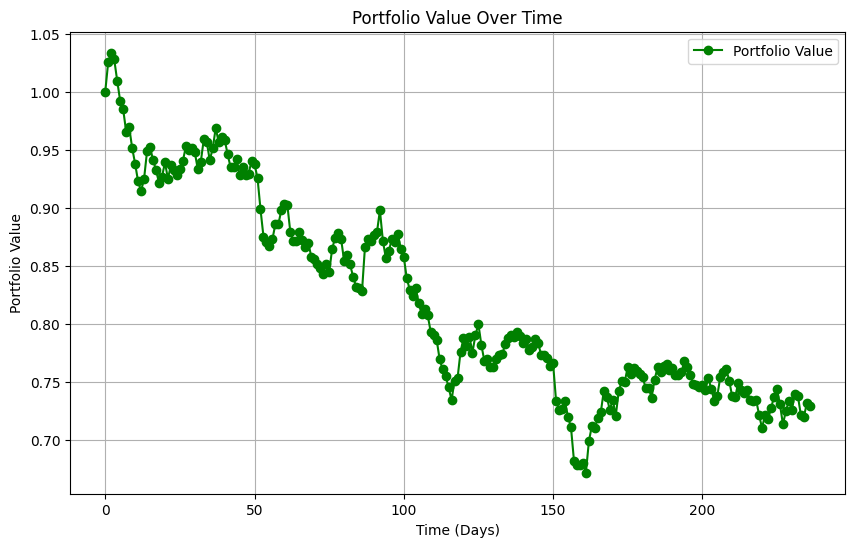

Epoch [5000/5000], Loss: 0.000312
Training complete!


In [38]:
# Initialize model with SARIMA components
model = GSarimaModel(
    time_steps=window_size,
    input_dim=num_features,
    num_companies=num_companies,
    device=torch.device(device),
    output_dim=1,
    K=2, # K =2
    ar_order=5, # =5
    ma_order=3, # =3
    seasonal_period=20 # =20
).to(device)

# Training with masked loss
criterion = nn.MSELoss(reduction='none')  # Don't reduce yet, we'll apply masks
optimizer = optim.Adam(model.parameters(), lr=0.01)

log_gsarima = []
train_start_time = time.time()
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(X_train, Adj_norm)  # [batch, companies, 1]

    # Calculate masked loss (only on valid samples)
    loss_per_sample = criterion(predictions, y_train)  # [batch, companies, 1]
    masked_loss = loss_per_sample * train_masks.unsqueeze(-1)  # Apply mask

    # Average loss over valid samples only
    num_valid = train_masks[:predictions.size(0)].sum() + 1e-8
    loss = masked_loss.sum() / num_valid

    # Backward pass
    loss.backward()
    optimizer.step()

    # For logging
    portfolio_value = 0
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test, Adj_norm) # torch.eye(num_companies, device=device))
        test_loss_per_sample = criterion(test_predictions, y_test)
        test_masked_loss = test_loss_per_sample * test_masks.unsqueeze(-1)
        test_loss = test_masked_loss.sum() / (test_masks.sum() + 1e-8)

        pred_price = test_predictions.squeeze(-1).cpu().numpy()  # [samples, companies]
        actual_price = y_test.squeeze(-1).cpu().numpy()
        first_day = 0

        expected_returns, actual_returns, portfolio_values = calculate_returns(pred_price, actual_price, first_day)

        if epoch == epochs-1:
          plot_portfolio_value(portfolio_values)

        portfolio_value = portfolio_values[-1]

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    log_gsarima.append([epoch, loss.item(), test_loss.item(), epoch_time, portfolio_value])

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("Training complete!")

# GNN

## GCNN (with K = 1)

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def build_graph_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device):
    """
    Build adjacency and degree matrices from relation encodings and masks

    Returns:
        adjacency_matrix: [num_companies, num_companies]
        degree_matrix: [num_companies, num_companies]
    """
    # Combine relation encodings by summing across relation types
    industry_adj = torch.sum(industry_encodings, dim=-1)  # [companies, companies]
    wiki_adj = torch.sum(wiki_encodings, dim=-1)

    combined_adj = industry_adj + wiki_adj

    combined_mask = industry_mask + wiki_mask
    #combined_adj = torch.where(combined_mask < -1e8, torch.zeros_like(combined_adj), combined_adj)
    degree_matrix = torch.diag(torch.pow(torch.sum(combined_adj, dim=1), -0.5))  # [companies, companies]

    S =  degree_matrix @ combined_adj.float() @  degree_matrix

    # Optional: small residual mix to stabilize training
    alpha = 0.4
    S = alpha * S + (1 - alpha) * torch.eye(S.size(0))

    return S.to(device)

def prepare_data(eod_data, masks, base_price, device, window_size=20, prediction_horizon=1):
    """
    Create sliding windows for time series prediction with mask handling

    Returns:
        X: Input windows [num_samples, num_companies, window_size, num_features]
        y: Target returns [num_samples, num_companies, prediction_horizon]
        sample_masks: Valid sample indicators [num_samples, num_companies]
    """
    num_companies, num_days, num_features = eod_data.shape
    num_samples = num_days - window_size - prediction_horizon + 1

    X = torch.zeros(num_samples, num_companies, window_size, num_features, device=device)
    y = torch.zeros(num_samples, num_companies, prediction_horizon, device=device)
    sample_masks = torch.zeros(num_samples, num_companies, device=device)

    for i in range(num_samples):
        X[i] = eod_data[:, i:i+window_size, :]
        y[i, :, :] = base_price[:, i+window_size : i+window_size+prediction_horizon] #

        # A sample is valid if all days in the window AND the target day are valid
        window_valid = masks[:, i:i+window_size].min(dim=1)[0]  # [num_companies]
        target_valid = masks[:, i+window_size : i+window_size+prediction_horizon].min(dim=1)[0]
        sample_masks[i] = window_valid * target_valid

    return X, y, sample_masks

class GCNModel(nn.Module):
    def __init__(self, layers_dim, num_companies, S, device, K=1, L=1):
        """
        Args:
            input_dim: Number of features * window_size per company
            output_dim: Prediction dimension (1 for return prediction)
            num_companies: Number of stocks (e.g., 150)
            K: Number of graph hops
        """
        super(GCNModel, self).__init__()
        self.device = device
        self.K = K
        self.L = L
        self.num_companies = num_companies
        self.layers_dim = layers_dim

        # Compute powers of adjacency matrix: A^0 (self), A^1 (neighbors), A^2 (2-hop), ...
        self.S = S
        self.linear_layers = nn.ModuleList(nn.Linear(self.layers_dim[i], self.layers_dim[i+1]) for i in range(L))


    def forward(self, x):
        """
        Args:
            x: Historical data [batch, num_companies, time_steps, input_dim]
            adjacency_matrix: Graph structure [num_companies, num_companies]
        Returns:
            predictions: [batch, num_companies, output_dim]
        """
        batch_size = x.shape[0]
        x_reshaped = x.view(x.shape[0], x.shape[1], -1) # [batch, companies, time_steps * features]
        output = x_reshaped
        for i in range(self.L):
            output = self.linear_layers[i](output)
            transformed = torch.matmul(self.S, output)
            output = torch.relu(transformed)
        return output

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load data
num_companies = eod_data.shape[0] # Change if using subset
num_days = 1245
num_features = 5

eod_data = torch.tensor(eod_data)
masks = torch.tensor(eod_masks)
price_prediction = torch.tensor(eod_base_price) # We predict stock price

# Relation data
industry_encodings = torch.tensor(industry_encodings)
industry_mask = torch.tensor(industry_mask)
wiki_encodings = torch.tensor(wiki_encodings)
wiki_mask = torch.tensor(wiki_mask)

print(f"EOD data shape: {eod_data.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Ground truth shape: {price_prediction.shape}")
print(f"Industry encodings shape: {industry_encodings.shape}")

Using device: cuda


/tmp/ipython-input-168932865.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eod_data = torch.tensor(eod_data)
/tmp/ipython-input-168932865.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  industry_encodings = torch.tensor(industry_encodings)
/tmp/ipython-input-168932865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  industry_mask = torch.tensor(industry_mask)
/tmp/ipython-input-168932865.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone

EOD data shape: torch.Size([1026, 1245, 5])
Masks shape: torch.Size([1026, 1245])
Ground truth shape: torch.Size([1026, 1245])
Industry encodings shape: torch.Size([1026, 1026, 97])


Epoch [50/5000], Loss: 0.003107
Epoch [100/5000], Loss: 0.002895
Epoch [150/5000], Loss: 0.002762
Epoch [200/5000], Loss: 0.002631
Epoch [250/5000], Loss: 0.002511
Epoch [300/5000], Loss: 0.002413
Epoch [350/5000], Loss: 0.002338
Epoch [400/5000], Loss: 0.002282
Epoch [450/5000], Loss: 0.002229
Epoch [500/5000], Loss: 0.002194
Epoch [550/5000], Loss: 0.002163
Epoch [600/5000], Loss: 0.002134
Epoch [650/5000], Loss: 0.002108
Epoch [700/5000], Loss: 0.002085
Epoch [750/5000], Loss: 0.002063
Epoch [800/5000], Loss: 0.002045
Epoch [850/5000], Loss: 0.004681
Epoch [900/5000], Loss: 0.002038
Epoch [950/5000], Loss: 0.002015
Epoch [1000/5000], Loss: 0.002003
Epoch [1050/5000], Loss: 0.001992
Epoch [1100/5000], Loss: 0.002030
Epoch [1150/5000], Loss: 0.001998
Epoch [1200/5000], Loss: 0.001983
Epoch [1250/5000], Loss: 0.001974
Epoch [1300/5000], Loss: 0.001966
Epoch [1350/5000], Loss: 0.001959
Epoch [1400/5000], Loss: 0.003770
Epoch [1450/5000], Loss: 0.001985
Epoch [1500/5000], Loss: 0.001964


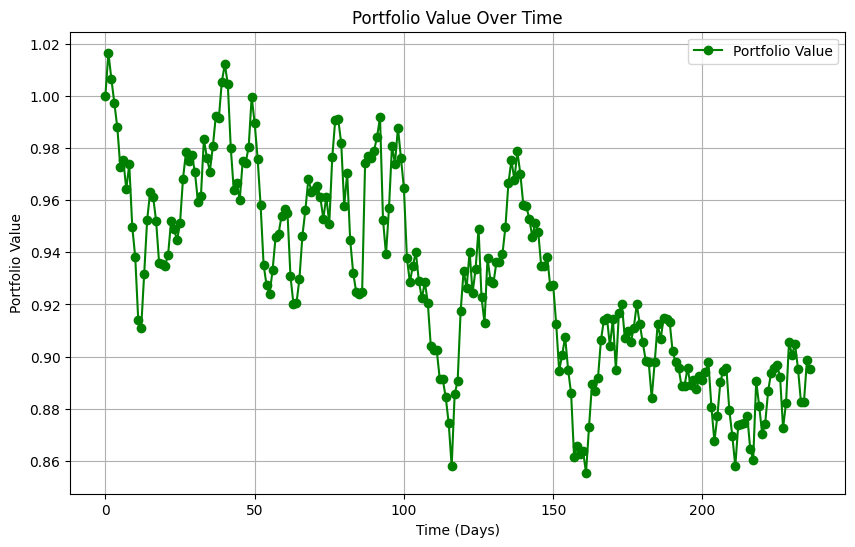

Epoch [5000/5000], Loss: 0.001876
Training completed


In [83]:

window_size=20
graph_shift_operator = build_graph_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device)
X_train, y_train, train_masks = prepare_data(
    eod_data=eod_data,
    masks=masks,
    base_price=price_prediction,
    device=device,
    window_size=window_size)

# Initialize model
model = GCNModel(
    layers_dim=[window_size*num_features, 100, 1],
    num_companies=num_companies,
    S=Adj_norm,
    device=device,
    K=1,
    L=2
).to(device)

# Training with masked loss
criterion = nn.MSELoss(reduction='none')  # Don't reduce yet, we'll apply masks
#criterion = nn.L1Loss(reduction='none')  # Don't reduce yet, we'll apply masks
optimizer = optim.Adam(model.parameters(), lr=0.005)

log_GCN = []
train_start_time = time.time()

epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    #predictions = model(X_train, adjacency_matrix)  # [batch, companies, 1]
    predictions = model(X_train)  # [batch, companies, 1]


    # Calculate masked loss (only on valid samples)
    loss_per_sample = criterion(predictions, y_train)  # [batch, companies, 1]
    masked_loss = loss_per_sample * train_masks.unsqueeze(-1)  # Apply mask

    # Average loss over valid samples only
    num_valid = train_masks[:predictions.size(0)].sum() + 1e-8
    #loss = masked_loss[:,:,model.output_dim-1].sum() / num_valid # Loss only for prediction_horizon day in future (1 day)
    loss = masked_loss.sum() / num_valid # Loss for all days up to prediction_horizon

    # Backward pass
    loss.backward()
    optimizer.step()

    # For logging
    portfolio_value = 0
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test) # torch.eye(num_companies, device=device))
        test_loss_per_sample = criterion(test_predictions, y_test)
        test_masked_loss = test_loss_per_sample * test_masks.unsqueeze(-1)
        test_loss = test_masked_loss.sum() / (test_masks.sum() + 1e-8)

        pred_price = test_predictions.squeeze(-1).cpu().numpy()  # [samples, companies]
        actual_price = y_test.squeeze(-1).cpu().numpy()
        first_day = 0

        expected_returns, actual_returns, portfolio_values = calculate_returns(pred_price, actual_price, first_day)

        if epoch == epochs-1:
          plot_portfolio_value(portfolio_values)

        portfolio_value = portfolio_values[-1]

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    log_GCN.append([epoch, loss.item(), test_loss.item(), epoch_time, portfolio_value])

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("Training completed")

## Graph RNN

In [65]:
class GRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_companies, S, device, output_size=1):
        """
        Init function
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_companies = num_companies

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

        self.device = device
        self.S = S


    def forward(self, x, hidden_state):
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        """
        x = torch.matmul(self.S, self.i2h(x))
        hidden_state = torch.matmul(self.S, self.h2h(hidden_state))
        hidden_state = torch.tanh(x + hidden_state)

        out = torch.matmul(self.S, self.h2o(hidden_state))
        return out, hidden_state


In [66]:
window_size=20
graph_shift_operator = build_graph_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device)
X_train, y_train, train_masks = prepare_data(
    eod_data=eod_data,
    masks=masks,
    base_price=price_prediction,
    device=device,
    window_size=window_size)

# Initialize model
model = GRNNModel(
    input_size=X_train.shape[-1],
    hidden_size=10,
    batch_size=X_train.shape[0],
    num_companies=num_companies,
    S=graph_shift_operator,
    device=device,
).to(device)

# Training with masked loss
criterion = nn.MSELoss(reduction='none')  # Don't reduce yet, we'll apply masks
#criterion = nn.L1Loss(reduction='none')  # Don't reduce yet, we'll apply masks
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_GraphRNN = []
train_start_time = time.time()

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    # predictions = model(X_train, adjacency_matrix)  # [batch, companies, 1]
    hidden_state = torch.zeros(model.batch_size, model.num_companies, model.hidden_size).to(device)

    # unroll through the window, we could add loss computaton here possibly
    for t in range(window_size):
        predictions, hidden_state = model(X_train[:, :, t, :], hidden_state)

    # now predictions is the final-step output: [batch, num_companies, 1]
    loss_per_sample = criterion(predictions, y_train)
    masked_loss = loss_per_sample * train_masks.unsqueeze(-1)
    num_valid = train_masks.sum() * 1.0 + 1e-8
    loss = masked_loss.sum() / num_valid

    # Backward pass
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("Training complted")

Epoch [1/100], Loss: 0.210972
Epoch [2/100], Loss: 0.196970
Epoch [3/100], Loss: 0.183538
Epoch [4/100], Loss: 0.170681
Epoch [5/100], Loss: 0.158402
Epoch [6/100], Loss: 0.146694
Epoch [7/100], Loss: 0.135544
Epoch [8/100], Loss: 0.124939
Epoch [9/100], Loss: 0.114866
Epoch [10/100], Loss: 0.105318
Epoch [11/100], Loss: 0.096294
Epoch [12/100], Loss: 0.087794
Epoch [13/100], Loss: 0.079820
Epoch [14/100], Loss: 0.072373
Epoch [15/100], Loss: 0.065456
Epoch [16/100], Loss: 0.059065
Epoch [17/100], Loss: 0.053199
Epoch [18/100], Loss: 0.047852
Epoch [19/100], Loss: 0.043016
Epoch [20/100], Loss: 0.038682
Epoch [21/100], Loss: 0.034837
Epoch [22/100], Loss: 0.031464
Epoch [23/100], Loss: 0.028547
Epoch [24/100], Loss: 0.026064
Epoch [25/100], Loss: 0.023990
Epoch [26/100], Loss: 0.022299
Epoch [27/100], Loss: 0.020960
Epoch [28/100], Loss: 0.019941
Epoch [29/100], Loss: 0.019207
Epoch [30/100], Loss: 0.018721
Epoch [31/100], Loss: 0.018446
Epoch [32/100], Loss: 0.018343
Epoch [33/100], L

KeyboardInterrupt: 

# GraphSage

In [67]:
 ###############################
  #                             #
  #       GraphSage Part        #
  #                             #
  ###############################

def sample_nodes_neighbourhood(sampled_companies, neighbourhood_size=5, k_hop=2):
    """
    Given set of comapnies sample number of neighbours in each k-hop neighbourhood
    """
    neighbours = sampled_companies.clone()

    for k in range(k_hop):
      k_hop_neighbours = torch.tensor([], dtype=torch.int32, device=device)
      for c in neighbours:
        # sample "neighbourhood_size" neighbours
        new_n_sample = torch.where(adjency_matrix[c] > 0)[0]
        new_n_sample = new_n_sample[torch.randperm(new_n_sample.shape[0])[:neighbourhood_size]]
        k_hop_neighbours = torch.cat((k_hop_neighbours, new_n_sample))

      # add kth neighbourhood to sampled companies
      sampled_companies = torch.cat((sampled_companies, k_hop_neighbours))
      neighbours = k_hop_neighbours.clone()

      # return unique node ids
      return sampled_companies.unique()

def prepare_samples_GraphSage(X_train, y_train, train_mask, adjency_matrix, S, device, sampled_nodes=50, neighbourhood_size=5, k_hop=2):
    """
    Prepares subgraphs for graph algorithms
    Returns arrays with sampled nodes

    X_train_sampled (an array): array of size num_batches with Tensors --> [time_samples, num_sampeled_companies, window, features]

    """
    time_samples, companies, window_size, num_features = X_train.shape
    num_batches = time_samples // sampled_nodes
    _, _, prediction_horizon = y_train.shape

    # initialize tensors
    X_train_sampled = []
    y_train_sampled = []
    train_mask_sampled = []
    S_sampled = []

    permutation = torch.randperm(companies, device=device)
    print(permutation)
    for i in range(num_batches):
      sampled_companies = permutation[i*sampled_nodes:(i+1)*sampled_nodes]
      sampled_companies = sample_nodes_neighbourhood(sampled_companies, neighbourhood_size, k_hop)


      X_train_sampled.append(X_train[:, sampled_companies, :, :])
      y_train_sampled.append(y_train[:, sampled_companies, :])
      train_mask_sampled.append(train_mask[:, sampled_companies])

      S_sampled.append(S[sampled_companies, sampled_companies])

    # NOTE: each batch can have different number of nodes
    return permutation, X_train_sampled, y_train_sampled, train_mask_sampled, S_sampled

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

eod_data = torch.tensor(eod_data)
masks = torch.tensor(eod_masks)
price_prediction = torch.tensor(eod_base_price) # We predict stock price

# Relation data
industry_encodings = torch.tensor(industry_encodings)
industry_mask = torch.tensor(industry_mask)
wiki_encodings = torch.tensor(wiki_encodings)
wiki_mask = torch.tensor(wiki_mask)

print(f"EOD data shape: {eod_data.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Ground truth shape: {price_prediction.shape}")
print(f"Industry encodings shape: {industry_encodings.shape}")
print("-----------")

window_size=10
S, adjency_matrix = build_graph_matrix(industry_encodings, industry_mask, wiki_encodings, wiki_mask, device)
X_train, y_train, train_masks = prepare_data(
    eod_data=eod_data,
    masks=masks,
    base_price=price_prediction,
    device=device,
    window_size=window_size)


X_train_sampled, y_train_sampled, train_mask, S_sampled = prepare_samples(X_train, y_train, train_masks, adjency_matrix, S, device)

print(f"X_train_sampled shape: {X_train_sampled.shape}")
print(f"y_train_sampled shape: {y_train_sampled.shape}")
print(f"train_mask shape: {train_mask.shape}")
print(f"S_sampled shape: {S_sampled.shape}")

Using device: cuda


/tmp/ipython-input-3670949924.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eod_data = torch.tensor(eod_data)
/tmp/ipython-input-3670949924.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  industry_encodings = torch.tensor(industry_encodings)
/tmp/ipython-input-3670949924.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  industry_mask = torch.tensor(industry_mask)
/tmp/ipython-input-3670949924.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().cl

EOD data shape: torch.Size([1026, 1245, 5])
Masks shape: torch.Size([1026, 1245])
Ground truth shape: torch.Size([1026, 1245])
Industry encodings shape: torch.Size([1026, 1026, 97])
-----------
tensor([189, 952, 872,  ...,  63, 622, 606], device='cuda:0')


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

# Logging

In [84]:
# Save Log to File
log = log_GCN
filename = 'log_NYSE_g.csv'

# Compute average training time per epoch
total_training_time = time.time() - train_start_time
avg_epoch_time = total_training_time / epochs

import pandas as pd

log_df = pd.DataFrame(log, columns=['Epoch', 'Train Loss', 'Test Loss', 'Epoch Time (s)', 'Portfolio Value'])
log_df['Avg Epoch Time (s)'] = avg_epoch_time  # Add the average epoch time to all rows

# Save log to CSV
log_df.to_csv(dir + '/output/' + filename, index=False)

print(f'Training completed. Log saved to /output')

Training completed. Log saved to /output


/tmp/ipython-input-1110785823.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=8)


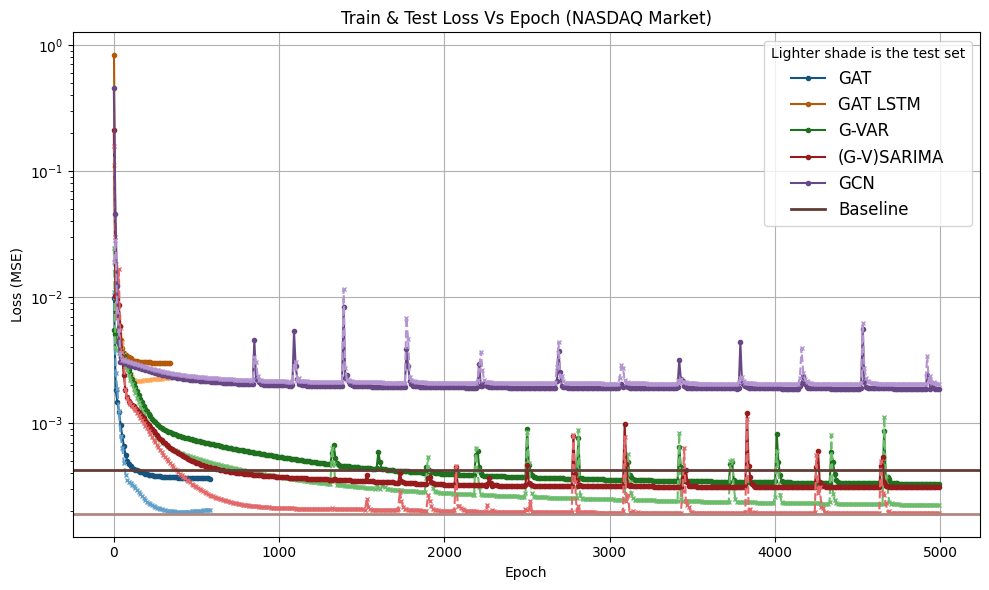

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from itertools import cycle


from matplotlib.colors import to_rgb

# Load model CSVs with names
def load_model_data2(file_paths_and_model_names):
    model_data = {}
    for file_path, model_name in file_paths_and_model_names:  # <- unpack list elements
        model_data[model_name] = pd.read_csv(file_path)
    return model_data

def lighten(color, amount=0.5):
    r, g, b = to_rgb(color)
    # move each channel halfway toward white
    return (1 - amount) * r + amount, (1 - amount) * g + amount, (1 - amount) * b + amount

def darken(color, amount=0.5):
    r, g, b = to_rgb(color)
    # move each channel toward black
    return amount * r, amount * g, amount * b

# Function to load the CSV files and return a DataFrame
def load_model_data(file_paths):
    model_data = {}
    for file in file_paths:
        model_name = os.path.basename(file).replace('.csv', '')  # Extract model name from file name
        model_data[model_name] = pd.read_csv(file)
    return model_data

# Function to plot the data
def plot_losses(model_data, step=10):
    plt.figure(figsize=(10, 6))  # Set plot size

    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    legend_handles = []  # We'll store one handle per model
    legend_labels = []

    for model_name, data in model_data.items():

        # Shared color for train & test
        base_color = next(color_cycle)
        train_color = darken(base_color, 0.7)
        test_color = lighten(base_color, 0.3)

        # If baseline (only one row), plot horizontal lines
        if len(data) == 1:
            base_train_value = data['Train Loss'].iloc[0]
            train_line = plt.axhline(y=base_train_value, linestyle='-', linewidth=2, color=train_color)
            base_test_value = data['Test Loss'].iloc[0]
            test_line = plt.axhline(y=base_test_value, linestyle='-', linewidth=2, color=test_color)

            legend_handles.append(train_line)
            legend_labels.append(model_name)

            continue

        # Downsample: plot every nth point
        data = data.iloc[::step]

        # Train: circles, darker
        train_line = plt.plot(
            data['Epoch'], data['Train Loss'],
            linestyle='-', marker='o', markersize=3, color=train_color
        )

        # Test: crosses, lighter
        test_line = plt.plot(
            data['Epoch'], data['Test Loss'],
            linestyle='--', marker='x', markersize=3, color=test_color
        )

        # Add ONE legend entry per model, using the train line as representative
        legend_handles.append(train_line[0])
        legend_labels.append(model_name)


    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Train & Test Loss Vs Epoch (NASDAQ Market)')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True)
    plt.tight_layout()

    # Single-entry legend
    plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=12, title="Lighter shade is the test set")

    plt.show()


# List of paths to the CSV files with the model names
file_paths_and_model_names = [
    [dir + '/output/backup/NASDAQ_GAT_only_epoch_losses.csv', 'GAT'],
    [dir + '/output/backup/NASDAQ_GAT_LSTM_epoch_losses.csv', 'GAT LSTM'],
    [dir + '/output/backup/log_NASDAQ_gvar_K1_lr0_001.csv', 'G-VAR'],
    [dir + '/output/backup/log_NASDAQ_gsarima_K2_lr0_01.csv', '(G-V)SARIMA'],
    [dir + '/output/backup/log_NASDAQ_GCN_K_1_(layers_100_100_1).csv', 'GCN'],
    [dir + '/output/backup/log_NASDAQ_baseline.csv', 'Baseline'],
]

# Load data from the CSV files
model_data = load_model_data2(file_paths_and_model_names)

# Plot the losses
plot_losses(model_data, step=10)

# Visualize Predictions
Draft code, doesn't have to be perfect, used just of visualizing what's happening with the predictions.

In [ ]:

# ============================================================================
# Visualization Function - Will use the latest run model
# ============================================================================

def plot_predictions(pred_price, actual_price,
                     start_idx, num_companies_to_plot=5):
    """
    Plot predicted vs actual stock prices for random companies

    Args:
        model: Trained G-VAR model
        X_test: Test input data [num_samples, num_companies, window_size, features]
        y_test: Test ground truth returns [num_samples, num_companies, 1]
        adjacency_matrix: Graph structure
        start_idx: Starting day index in the original timeline
        num_companies_to_plot: Number of companies to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np

    #num_samples, num_companies, prediction_horizon = pred_price.shape
    num_samples, num_companies = pred_price.shape

    # Select 5 random companies
    np.random.seed(40)
    selected_companies = np.random.choice(num_companies, num_companies_to_plot, replace=False)

    # Create subplots
    fig, axes = plt.subplots(num_companies_to_plot, 1, figsize=(12, 3*num_companies_to_plot))
    if num_companies_to_plot == 1:
        axes = [axes]

    for idx, company_idx in enumerate(selected_companies):
        ax = axes[idx]

        #actual_prices = actual_price[:, company_idx, 0]
        actual_prices = actual_price[:, company_idx]
        #pred_prices = pred_price[:, company_idx, 0]
        pred_prices = pred_price[:, company_idx]
        time_steps = np.arange(start_idx, start_idx + len(actual_prices))

        # Plot
        ax.plot(time_steps, actual_prices, label='Actual Price',
               color='blue', linewidth=2, alpha=0.7)
        ax.plot(time_steps, pred_prices, label='Predicted Price',
               color='red', linewidth=2, linestyle='--', alpha=0.7)

        ax.set_xlabel('Day Index')
        ax.set_ylabel('Price')
        ax.set_title(f'Company {company_idx}: Predicted vs Actual Stock Price')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('stock_predictions.png', dpi=150, bbox_inches='tight')
    print("Plot saved as 'stock_predictions.png'")
    plt.show()


# ============================================================================
# Example: Plot predictions on test data
# ============================================================================

# Evaluate
model.eval()
with torch.no_grad():
  predictions = model(X_test, Adj_norm)  # [num_samples, companies, 1]

# Convert to numpy
pred_price = predictions.squeeze(-1).cpu().numpy()  # [samples, companies]
actual_price = y_test.squeeze(-1).cpu().numpy()


# Plot predictions
plot_predictions(
  pred_price=pred_price,
  actual_price=actual_price,
  start_idx=train_size + window_size,  # Offset by window size
  num_companies_to_plot=5
)

# Example Usage:
# Assume pred_price and actual_price are numpy arrays with shape (samples, companies)
# pred_price and actual_price are assumed to be already defined as numpy arrays

# Set the first_day parameter, for example, starting from day 50
first_day = 0

# Call the function to calculate the expected and actual returns
expected_returns, actual_returns, portfolio_values = calculate_returns(pred_price, actual_price, first_day)

# Plot the expected vs actual returns
plot_returns(expected_returns, actual_returns)

# Plot the portfolio value over time
plot_portfolio_value(portfolio_values)